# Python的内存管理与垃圾回收机制

变量与常量的目的---描述客观世界万事万物

变量放哪里了？---内存

CPU 只和内存交互，程序存放在当运硬盘中无法和 CPU 交互，就无法运行。当使用 Python 解释器进行解释时，变量就会进入到内存中。如果不用 Python 解释器解释时， a = 1 只是很普通的字符，和用 Word 或者记事本写的东西没有任何区别，__变量是 Python 里面的概念，只有被 Python 解释器解释时，它才具有变量这种意义__。

当我们把 a=1 写在 Pycharm 中，它也是存在内存里，但只是很普通的字符串。但当我们运行解释器后，成为变量存储在内存中。

In [ ]:
a = 1
# 内存开辟一内存小块空间，里面放着 1 ，这块空间的名称叫做 a 。

b = 2
# 内存开辟一内存小块空间，里面放着 2 ，这块空间的名称叫做 b 。

a = 2
# 内存开辟一内存小块空间，里面放着 2 ，这块空间的名称叫做 a 。

# 空间名称不可重复， 1 的空间名称被替换为空，成为垃圾
# python垃圾回收机制会启动，把 1 的内存空间释放掉。

### 引用计数
引用计数是针对变量值而言，而不是变量名。
- 创建变量，就开辟一块内存空间，将引用计数初始化为1；
- 删除变量（重新赋值），内存空间会少一个名称，引用计数 -1 ；
- 引用变量，内存空间会多一个名称，引用计数 +1 ；
- 当一个变量的引用计数为 0 的时候，就会启动垃圾回收机制。


In [7]:
c = 3
# 内存开辟一内存小块空间，里面放着 3 ，这块空间的名称叫做 c 。 
# 3 的引用计数为 1

d = c
print(c)
print(d)
# 不是定义变量，而是引用变量,内存空间会多一个空间名称
# 3 的引用计数 +1 ，为 2

c = 4 
print('----------------')
print(c)
print(d)
# 内存开辟一内存小块空间，里面放着 4 ，这块空间的名称叫做 c 。 
# 3 的引用计数 -1， 为 1


del d
# 3 的引用计数 -1，为 0 ，启动垃圾回收机制 ，把 3 这块内存空间清除

3
3
----------------
4
3


In [6]:
e = 1000 # 定义变量开辟新的内存空间
print(id(e))

f = e # 引用变量将引用计数器 +1 ，内存空间不变
print(id(f))

g = 1000 # 定义变量开辟新的内存空间
print(id(g))

2688955480176
2688955480176
2688955479728


### “引用计数器为主，标记清除和分代回收为辅+缓存机制”
- 引用计数器
- 标记清除
- 分代回收
- 缓存机制

## 一、引用计数器
在Python的C源码中有一个名为 __refchain的环状双向链表__，Python 程序中一旦创建对象都会把这个对象添加到 refchain 这个链表中。也就是说他保存着所有的对象。例如：

In [ ]:
age = 18
name = "武沛齐"

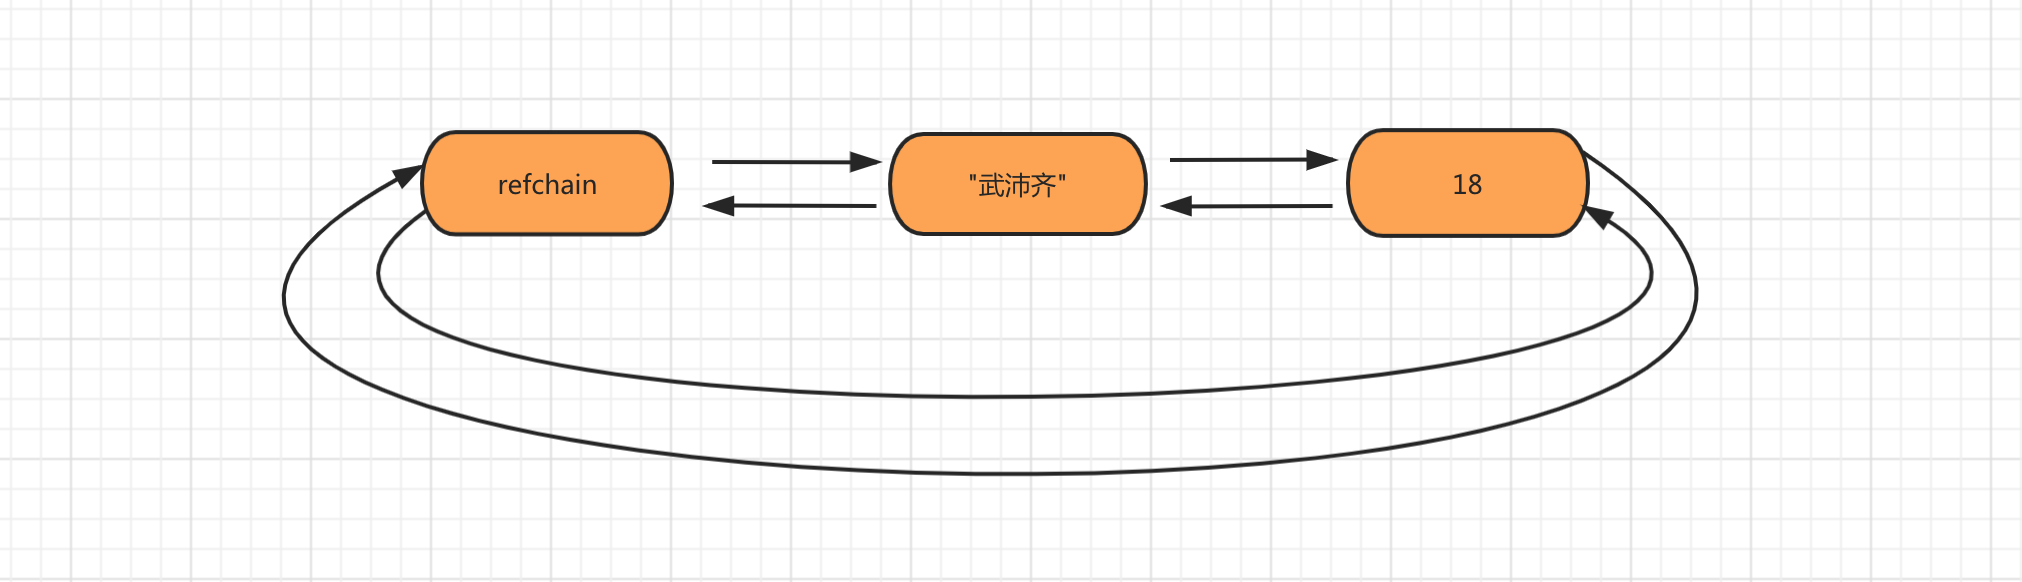
在refchain中的所有对象内部都有一个 __ob_refcnt__ 用来保存当前对象的__引用计数器__，顾名思义就是自己被引用的次数，例如：

In [ ]:
age = 18
name = "武沛齐"
nickname = name

上述代码表示内存中有 18 和 “武沛齐” 两个值，他们的引用计数器分别为：1、2 。
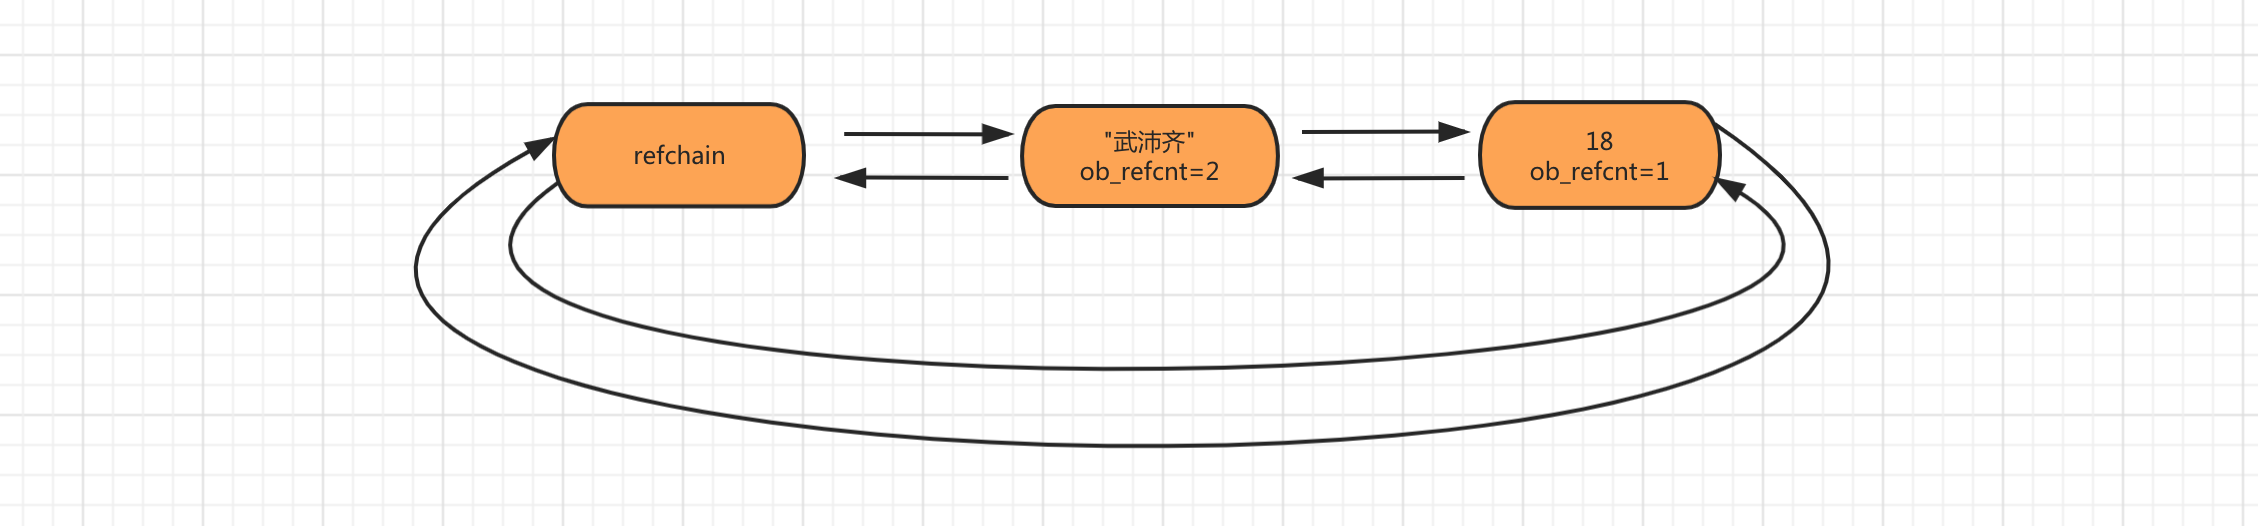
当值被多次__引用__时候，不会在内存中重复创建数据，而是__引用计数器 +1__ 。 当对象被 __销毁__ 时候同时会让 __引用计数器 -1__ , __如果引用计数器为 0 ，则将对象从 refchain 链表中摘除，同时在内存中进行销毁__（暂不考虑缓存等特殊情况）。

In [1]:
age = 18
number = age  # 对象18的引用计数器 + 1
del age          # 对象18的引用计数器 - 1
def run(arg):
    print(arg)
run(number)   # 刚开始执行函数时，对象18引用计数器 + 1，当函数执行完毕之后，对象18引用计数器 - 1 。
num_list = [11,22,number] # 对象18的引用计数器 + 1

18


## 二、标记清除

基于引用计数器进行垃圾回收非常方便和简单，但他还是存在__循环引用__的问题，导致无法正常的回收一些数据，例如：

In [ ]:
# 单向引用
c = 3 # 3 的引用计数为 1
d = c # 3 的引用计数 +1 ，为 2
del c # 3 的引用计数 -1， 为 1
del d # 3 的引用计数 -1，为 0 ，启动垃圾回收机制 ，把 3 这块内存空间清除

In [ ]:
# 循环引用
v1 = [11,22,33]        # refchain中创建一个列表对象，由于v1=对象，所以列表引对象用计数器为1.
v2 = [44,55,66]        # refchain中再创建一个列表对象，因v2=对象，所以列表对象引用计数器为1.
v1.append(v2)        # 把v2追加到v1中，则v2对应的[44,55,66]对象的引用计数器加1，最终为2.
v2.append(v1)        # 把v1追加到v1中，则v1对应的[11,22,33]对象的引用计数器加1，最终为2.
del v1    # 引用计数器-1,最终为1
del v2    # 引用计数器-1，最终为1

- 对于上述代码会发现，__执行del操作之后，没有变量再会去使用那两个列表对象，但由于循环引用的问题，他们的引用计数器不为0__，所以他们的状态：永远不会被使用、也不会被销毁。项目中如果这种代码太多，就会导致内存一直被消耗，直到内存被耗尽，程序崩溃。
- 为了解决循环引用的问题，引入了__标记清除__技术，专门针对那些__可能存在循环引用的对象__进行特殊处理，可能存在循环应用的类型有：列表、元组、字典、集合、自定义类等那些__能进行数据嵌套的类型__。
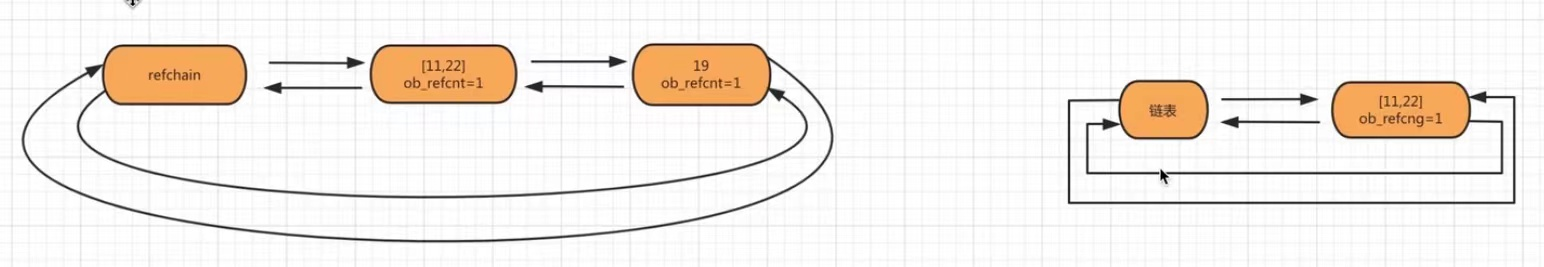
- __目的__：为了解决引用计数器__循环引用__的不足。
- __实现__：在 python 底层再维护一个链表，专门放那些可能存在循环引用的对象（list/tuple/dict/set）。在__某种情况下__触发，回去扫描__可能存在循环引用的链表__中的每个元素，检查是否有循环引用，如果有，且双方引用计数器 -1 的结果是 0 则垃圾回收。


__问题：__
- 什么情况下会触发扫描？
- 对可能存在循环引用的链表进行扫描代价比较大，每次扫描耗时久，如何解决？
- 引入分代回收。

## 三、分代回收
__分代回收__：对标记清除中的链表进行优化，将那些可能存在循引用的对象__拆分到3个链表__，链表称为：0/1/2三代，每代都可以存储对象和阈值，当达到阈值时，就会对相应的链表中的每个对象做一次扫描，除循环引用各自减1并且销毁引用计数器为0的对象。
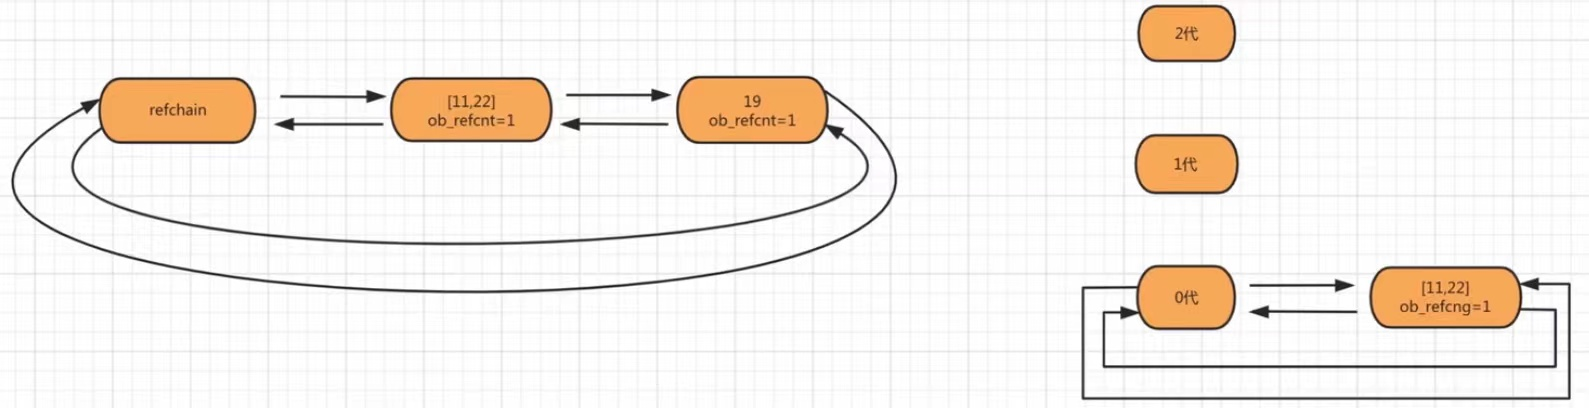
多久扫描一次？
- 0代，0代中对象个数达到700个，则扫描一次0代；
- 1代，0代扫描10次，1代扫描一次；
- 2代，1代扫描10次，2代扫描一次。
- 阈值：0代是对象个数，而1代和2代是扫描次数。

对象个数达到700,0代扫描一次---是循环引用，且是垃圾，则清除；不是垃圾则升级进入1代---0代扫描10次后，1代扫描一次。

- 小结：在 Python 中，有维护一个 __refchain 双向环状链表__，链表中存储我们程序中创建的所有对象，每一个对象中都有一个 __refcnt 的值__，即引用计数器的值，它维护着引用的个数。当引用计数器变为0时，则会进行 __垃圾回收__（对象销毁、refchain中移除）。但是在python中对于可以有多个元素组成的对象，可能存在__循环引用__的问题，因此python又引入了 __标记清除和分代回收__，在其内部，__共维护4个链表，分别是refchain、分代2代、1代、0代__，在源码内部，当达到各自阈值时，就会触发扫描链表进行标记清除动作。

- 在上述流程中，又提出了一个优化机制，即缓存机制，让 Python 性能更高。

## 四、缓存机制
从上文大家可以了解,到当对象的引用计数器为0时，就会被销毁并释放内存。而实际上他不是这么的简单粗暴，因为 __反复的创建和销毁变量、分配和释放内存会使程序的执行效率变低,因此 Python 中引入了“缓存机制”__。

大家都知道现实生活中很多场景都符合二八定律，在程序中也是一样，__经常被使用的数据对象可能会占据所有数据对象使用频率的80%__，因此为了优化程序，提高程序的执行效率，Python解释器会将常用数据对象放在缓存中，一旦使用时，将数据对象的引用传递过去即可。

Python缓冲机制是为提高程序执行的效率服务的，实际上就是 __在Python解释器启动时从内存空间中开辟出一小部分,用来存储高频使用的对象__，这样可以 __大大减少高频使用的数据对象创建时申请内存和销毁时撤销内存的开销__。

缓存分为两大类：
- __池__：避免重复创建和销毁一些常见对象，会维护一个池 (引用计数器初始化为 1 )。

> int 类型，不是基于 free_list ，而是维护一个 small_ints 链表保存常见数据（小数据池），小数据池范围：-5 <= value < 257 。即：重复使用这个范围的整数时，不会重新开辟内存。

> str 类型，维护 unicode_latin1[256] 链表，内部将所有的 ascii 字符缓存起来，以后使用时就不再反复创建。

- __free_list__：引用计数器为 0 时，按理说应该回收，而 Python 内部不会回收，而是将对象添加到 free_list 链表中，当成缓存，以后再创建对象时，就不再重新开辟内存，而是直接使用 free_list 。

> float 类型，维护的 free_list 链表最多可缓存100个float对象。

> list 类型，维护的 free_list 数组最多可缓存80个list对象。

> tuple 类型，维护一个 free_list 数组且数组容量20，数组中元素可以是链表且每个链表最多可以容纳 2000 个元组对象。元组的 free_list 数组在存储数据时，是按照元组可以容纳的个数为索引找到 free_list 数组中对应的链表，并添加到链表中。

> dict 类型，维护的 free_list 数组最多可缓存80个dict对象。

In [2]:
# 池, 没有引用，但地址相同
v1 = 256
print(id(v1))
v2 = 256
print(id(v2))

2190758275472
2190758275472


In [2]:
# free_list
v3 = [1,2,3]
print(id(v3))
del v3
v4 = ['x','m','u']
print(id(v4))
# 交互式运行，每一行为一个独立的代码块，因此地址不同
# 文件式运行，文件是一个代码块得到的地址一致

2061793310400
2061793284288


### 小结
- __引用计数__：__创建变量__即开辟一块新的内存空间，即在 refchain 链表中增加一个元素，引用计数为 1 ；__引用变量__引用计数器 +1 ；__删除变量__引用计数器 -1 ，__引用计数为 0 时进行垃圾回收__。
- __标记清除__：由于部分对象间存在__循环引用问题__，因此为这些对象__另外维护一个链表__，并且定期扫描。扫描到循环引用，如果引用计数 -1 后计数为 0 ，则作为垃圾回收。
- __分代回收__：__将新维护的链表分为三代__，达到各自阈值时进行扫描，提升运行效率。
- __缓存机制__：一方面通过__池__的方式将常用对象地址固定，避免重复申请与销毁内存；另一方面也通过 __free_list__ 链表对一定数量的垃圾地址回收，方便再次利用。